In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle mediapipe opencv-python imgaug pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
thinc 8.3.6 requires

In [ ]:
!cp /content/drive/MyDrive/BISINDO/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d achmadnoer/alfabet-bisindo

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [ ]:
!cp alfabet-bisindo.zip /content/drive/MyDrive/

cp: cannot stat 'alfabet-bisindo.zip': No such file or directory


In [ ]:
import numpy as np
import mediapipe as mp

print("NumPy version:", np.__version__)
print("Mediapipe imported successfully!")


NumPy version: 1.26.4
Mediapipe imported successfully!


In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import joblib
import imgaug.augmenters as iaa
import sklearn

In [ ]:
print(f'Mediapipe Version: {mp.__version__}')
print(f'OpenCV Version: {cv2.__version__}')
print(f'Pandas Version: {pd.__version__}')
print(f'Numpy Version: {np.__version__}')
print(f'Scikit Learn Version: {sklearn.__version__}')
print(f'Joblib Version: {joblib.__version__}')


Mediapipe Version: 0.10.21
OpenCV Version: 4.11.0
Pandas Version: 2.2.2
Numpy Version: 1.26.4
Scikit Learn Version: 1.6.1
Joblib Version: 1.5.1


In [ ]:
IMG_HEIGHT    = 256
IMG_WIDTH     = 256

INPUT_DIR     = '/content/drive/MyDrive/BISINDO/Datasets/bisindo'
AUGMENTED_DIR = '/content/drive/MyDrive/BISINDO/Datasets/bisindo-augmented'
CSV_FILENAME  = '/content/drive/MyDrive/BISINDO/Datasets/bisindo-features.csv'

TRAIN_CSV     = '/content/drive/MyDrive/BISINDO/Datasets/bisindo-train.csv'
VAL_CSV       = '/content/drive/MyDrive/BISINDO/Datasets/bisindo-val.csv'
TEST_CSV      = '/content/drive/MyDrive/BISINDO/Datasets/bisindo-test.csv'

NUM_AUGMENTED_IMAGE = 50


In [ ]:
seq = iaa.Sequential([
    iaa.Resize((IMG_HEIGHT, IMG_WIDTH)),
    iaa.Fliplr(0.5),
    iaa.Affine(rotate=(-25, 25)),
    iaa.Multiply((0.8, 1.2)),
    iaa.GaussianBlur(sigma=(0, 1.0))
])

def augment_images(input_dir, output_dir, num_augmented_image):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for letter in os.listdir(input_dir):
        letter_path = os.path.join(input_dir, letter)
        output_letter_path = os.path.join(output_dir, letter)
        os.makedirs(output_letter_path, exist_ok=True)

        for img_file in os.listdir(letter_path):
            img_path = os.path.join(letter_path, img_file)
            img = cv2.imread(img_path)

            for i in range(num_augmented_image):  # Augment each image X times
                augmented_image = seq(image=img)
                cv2.imwrite(os.path.join(output_letter_path, f"{img_file[:-4]}_aug_{i}.jpg"), augmented_image)

augment_images(INPUT_DIR, AUGMENTED_DIR, NUM_AUGMENTED_IMAGE)


In [ ]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def extract_landmarks(image):
    with mp_hands.Hands(static_image_mode=True, max_num_hands=2) as hands:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)
        if results.multi_hand_landmarks:
            landmarks = []
            for hand_landmarks in results.multi_hand_landmarks:
                for lm in hand_landmarks.landmark:
                    landmarks.append([lm.x, lm.y, lm.z])
            return landmarks
    return None

def process_images(input_dir, csv_filename):
    data = []
    for letter in sorted(os.listdir(input_dir)):
        letter_path = os.path.join(input_dir, letter)
        label = letter
        print(f'Processing {label}')
        for img_file in sorted(os.listdir(letter_path)):
            img_path = os.path.join(letter_path, img_file)
            img = cv2.imread(img_path)
            landmarks = extract_landmarks(img)
            if landmarks:  # Only save if landmarks were detected
                row = [label] + [coord for lm in landmarks for coord in lm]
                data.append(row)

    columns = ['label'] + [f'hand_{i}_x' for i in range(42)] + [f'hand_{i}_y' for i in range(42)] + [f'hand_{i}_z' for i in range(42)]
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(csv_filename, index=False)

    print('Image Features Extracted')

process_images(AUGMENTED_DIR, CSV_FILENAME)



Processing A
Processing B
Processing C
Processing D
Processing E
Processing F
Processing G
Processing H
Processing I
Processing J
Processing K
Processing L
Processing M
Processing N
Processing O
Processing P
Processing Q
Processing R
Processing S
Processing T
Processing U
Processing V
Processing W
Processing X
Processing Y
Processing Z
Image Features Extracted


In [ ]:
# Load datasets
df = pd.read_csv(CSV_FILENAME)
df.fillna(0, inplace=True)
df.head()

,label,hand_0_x,hand_1_x,hand_2_x,hand_3_x,hand_4_x,hand_5_x,hand_6_x,hand_7_x,hand_8_x,...,hand_32_z,hand_33_z,hand_34_z,hand_35_z,hand_36_z,hand_37_z,hand_38_z,hand_39_z,hand_40_z,hand_41_z
0,A,0.971309,0.782056,-5.577339e-07,0.826409,0.777731,-0.027959,0.722821,0.729997,-0.073362,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A,0.024386,0.749983,3.944932e-07,0.149282,0.751472,-0.028956,0.255112,0.717235,-0.082129,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A,0.090712,0.867306,1.261997e-07,0.213761,0.828042,-0.035340,0.309555,0.764432,-0.092597,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A,0.903932,0.871559,-8.515703e-07,0.780292,0.820358,-0.040271,0.686488,0.756586,-0.091283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A,0.105451,0.866061,2.097936e-07,0.222607,0.831990,-0.036928,0.312384,0.770206,-0.093670,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def split_data(csv_filename, train_csv_dir, val_csv_dir, test_csv_dir):
    df = pd.read_csv(csv_filename)
    train, temp = train_test_split(df, test_size=0.3, stratify=df['label'])
    val, test = train_test_split(temp, test_size=0.5, stratify=temp['label'])

    train.to_csv(train_csv_dir, index=False)
    val.to_csv(val_csv_dir, index=False)
    test.to_csv(test_csv_dir, index=False)

split_data(CSV_FILENAME, TRAIN_CSV, VAL_CSV, TEST_CSV)

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)

train = train_df.fillna(0)
val = val_df.fillna(0)
test = test_df.fillna(0)

train.head()

,label,hand_0_x,hand_1_x,hand_2_x,hand_3_x,hand_4_x,hand_5_x,hand_6_x,hand_7_x,hand_8_x,...,hand_32_z,hand_33_z,hand_34_z,hand_35_z,hand_36_z,hand_37_z,hand_38_z,hand_39_z,hand_40_z,hand_41_z
0,X,0.022652,0.635158,8.480893e-07,0.112190,0.555572,-0.026083,0.259887,0.569210,-0.088454,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,L,0.048317,0.670461,-5.367982e-10,0.206771,0.715699,-0.022349,0.385796,0.702351,-0.049014,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,W,0.678176,0.989323,-6.257412e-07,0.601082,0.864628,-0.043847,0.574006,0.709337,-0.080750,...,-0.115889,0.060661,0.505960,-0.157744,0.042655,0.574237,-0.146766,-0.001317,0.581599,-0.131001
3,D,0.171137,0.766886,2.318192e-07,0.224633,0.745680,-0.054255,0.267480,0.695651,-0.087176,...,-0.059928,0.576638,0.410306,-0.076320,0.573780,0.459117,-0.058360,0.596383,0.469069,-0.041869
4,I,0.212434,0.649922,-8.823343e-07,0.353692,0.730277,-0.046694,0.475337,0.757785,-0.097511,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
X_train = train.drop(columns=['label'])
y_train = train['label']
X_val = val.drop(columns=['label'])
y_val = val['label']
X_test = test.drop(columns=['label'])
y_test = test['label']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


            Classifier  Validation Accuracy  Validation F1 Score  \
0        Random Forest             0.995394             0.995407   
1                  SVM             0.863657             0.857030   
2  Logistic Regression             0.837402             0.834209   
3  K-Nearest Neighbors             0.982957             0.982979   
4        Decision Tree             0.960848             0.960993   
5    Gradient Boosting             0.988945             0.988966   
6          Naive Bayes             0.413174             0.314999   

   Test Accuracy  Test F1 Score  
0       0.994475       0.994470  
1       0.865101       0.857700  
2       0.836096       0.833702  
3       0.977901       0.977740  
4       0.957182       0.956991  
5       0.987109       0.987103  
6       0.417127       0.314156  


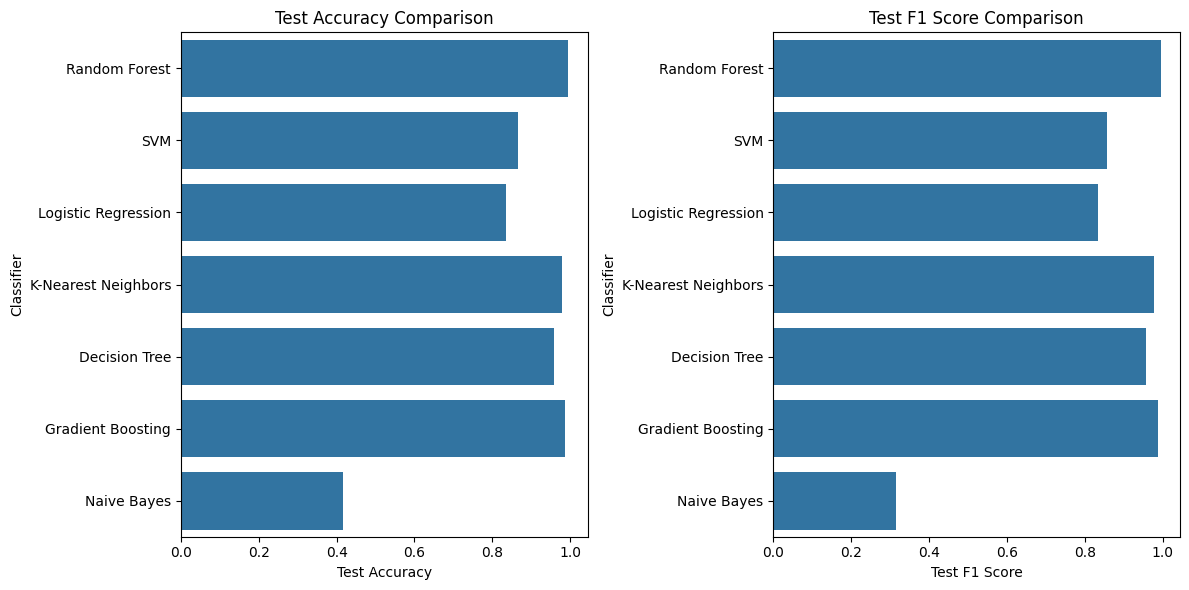

In [12]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Naive Bayes': GaussianNB()
}

results = []

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)

    y_val_pred = clf.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')

    y_test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')

    results.append({
        'Classifier': name,
        'Validation Accuracy': val_accuracy,
        'Validation F1 Score': val_f1,
        'Test Accuracy': test_accuracy,
        'Test F1 Score': test_f1
    })

results_df = pd.DataFrame(results)

print(results_df)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Test Accuracy', y='Classifier', data=results_df)
plt.title('Test Accuracy Comparison')

plt.subplot(1, 2, 2)
sns.barplot(x='Test F1 Score', y='Classifier', data=results_df)
plt.title('Test F1 Score Comparison')

plt.tight_layout()
plt.show()


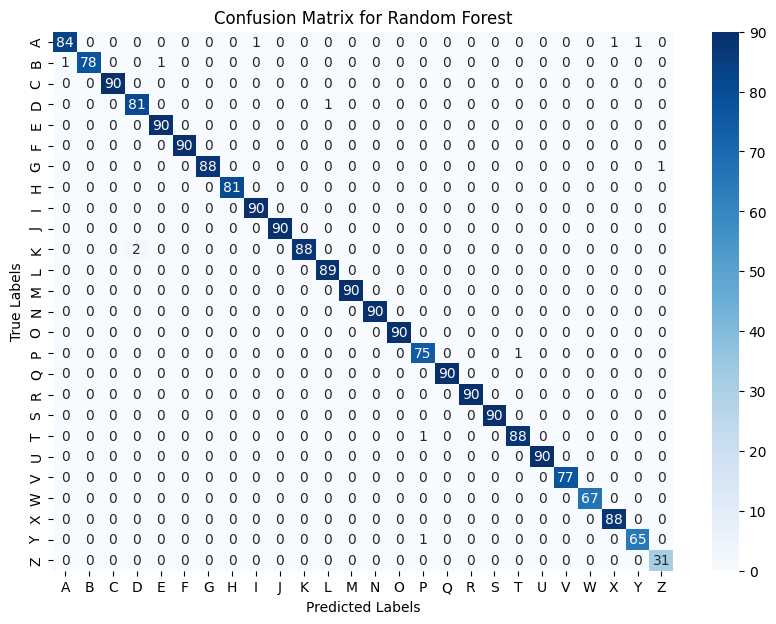

In [13]:
random_forest_clf = classifiers['Random Forest']

y_test_pred_rf = random_forest_clf.predict(X_test)

conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=random_forest_clf.classes_, yticklabels=random_forest_clf.classes_)

plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [14]:
import joblib

clf = classifiers['Random Forest']

model_filename = '/content/drive/MyDrive/BISINDO/rf_bisindo_classifier_99.pkl'
joblib.dump(clf, model_filename)

print(f"Random Forest model saved to {model_filename}")

Random Forest model saved to /content/drive/MyDrive/BISINDO/rf_bisindo_classifier_99.pkl
